#INSTALADORES

In [1]:
!pip install tensorboard
!pip install torchinfo
!pip install --upgrade torch torchvision
!pip install ray
!pip install tensorboardX

#GOOGLE DRIVE

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! cp "/content/drive/MyDrive/Colab Notebooks/MLP/data.csv" /content
! cp "/content/drive/MyDrive/Colab Notebooks/MLP/img.zip" /content
! unzip -q img.zip
! rm img.zip

replace __MACOSX/._img? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#Weights and Biases INICIALIZACION

In [4]:
!pip install wandb
!wandb login

#59faca4190d33815ba5b1ce0a93431b26067d3a8

import wandb

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


#FUNCIONES BASE ENTRENO

In [29]:
import time
import datetime
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from fastprogress import master_bar, progress_bar
from torch.utils.tensorboard import SummaryWriter
import torchinfo
import numpy as np
import random
import pandas as pd
import csv
from PIL import Image
import os

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

from sklearn.metrics import accuracy_score, confusion_matrix

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [30]:
def train_step(mlp_model, criterion, optim, img,tabulars, label, batch_size, numberOfClass):
    optim.zero_grad()
    output = mlp_model(img, tabulars)
    loss = criterion(output, label)
    loss.backward()
    optim.step()
    step_loss = loss.item()
    return step_loss

def train_epoch(mlp_model, loader, criterion, optim,mb,numberOfClass):
    epoch_loss_accumulated = 0.0
    for img, tabulars, labels in  progress_bar(loader,parent = mb):
      batch_size = img.size(0)
      epoch_loss_accumulated += train_step(mlp_model,criterion,optim, img.to(device), tabulars.to(device), labels.to(device), batch_size,numberOfClass)
    return epoch_loss_accumulated/len(loader)

In [31]:
def validation_epoch(mlp_model, val_loader, criterion, classes = None):
    mlp_model.eval()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
      for images, tabulars, labels in val_loader:
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
        tabulars = tabulars.to(device)
        labels = labels.to(device)
        predictions = mlp_model(images.to(device), tabulars)
        all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())
        loss = criterion(predictions, labels)

        epoch_loss += loss.item()

    return epoch_loss / len(val_loader), accuracy_score(all_labels, all_predictions) * 100

In [32]:
def train_model(mlp_model, train_loader, valid_loader, criterion, optim, number_epochs,numberOfClass):
  train_history = []
  valid_history = []
  accuracy_history = []
  now = datetime.datetime.now()
  date_time = now.strftime("%m%d%Y_%H%M%S")
  name = 'runs/'+mlp_model.name+'_'+date_time
  tensorBoard_writer = SummaryWriter(name)
  mb = master_bar(range(1, number_epochs+1))
  for epoch in mb:
      start_time = time.time()
      train_loss = train_epoch(mlp_model, train_loader, criterion, optim,mb,numberOfClass)
      train_history.append(train_loss)
      print("Training epoch {} | Loss {:.6f} | Time {:.2f} seconds"
            .format(epoch + 1, train_loss, time.time() - start_time))

      start_time = time.time()
      val_loss, acc = validation_epoch(mlp_model, valid_loader, criterion)
      valid_history.append(val_loss)
      accuracy_history.append(acc)
      print("Validation epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, val_loss, acc, time.time() - start_time))
      # Se carga en tensorBoard #Loss #Validation en train y val
      wandb.log({"Train Loss": train_loss})
      wandb.log({"Validation Loss": val_loss})
      wandb.log({"Accuracy": acc})

      tensorBoard_writer.add_scalar(tag="Train Loss", scalar_value=train_loss, global_step=epoch)
      tensorBoard_writer.add_scalar(tag="Validation Loss", scalar_value=val_loss, global_step=epoch)
      tensorBoard_writer.add_scalar(tag="Validation Accuracy", scalar_value=acc, global_step=epoch)
  tensorBoard_writer.close()

#CARGA DE DATOS

In [22]:
# Creamos los dataloaders
val_transform = transforms.Compose([
    transforms.Resize([256,192]),
])

train_transform = transforms.Compose([
    transforms.Resize([256,192]),
    transforms.RandomRotation(degrees=(0,45)),
    transforms.ColorJitter(hue=(-0.05,0.05))
])

In [23]:
from torch.utils.data import Dataset
from torchvision.io import read_image
import os

class MLP_Dataset(Dataset):
    def __init__(self, image_dir='./img/', data_dir='./data.csv', transform=None):
        self.image_dir = image_dir
        self.data_dir = data_dir

        self.transform = transform

        self.tabular_data = self.openDataFile()
        arr = np.array(self.tabular_data)
        print(arr.shape)

        self.tabular_data = list(filter(self.hasImage, self.tabular_data))
        self.labels = torch.tensor(list(map(self.targetToClass, self.tabular_data)))

        #image file is not to be changed to numpy
        self.image_files = [str(row[0]) for row in self.tabular_data]
        self.tabular_data = torch.tensor(np.array(self.tabular_data)[:,1:6])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = torchvision.io.read_image(img_path)

        tabular_data = self.tabular_data[idx]
        label = self.labels[idx]

        if self.transform:
          image = self.transform(image)

        return image,tabular_data, label

    def hasImage(self, line):
      image_path = os.path.join(self.image_dir + str(line[0]))
      return os.path.isfile(image_path)

    def targetToClass(self, line):
        label = [1.0,0.0,0.0,0.0]
        if line[6] > 100000 and line[6] <= 200000:
          label = [0.0,1.0,0.0,0.0]
        elif line[6] > 200000 and line[6] <= 300000:
          label = [0.0,0.0,1.0,0.0]
        elif line[6] > 300000:
          label = [0.0,0.0,0.0,1.0]
        return label

    def openDataFile(self):
      tabular_data = []
      with open(self.data_dir, 'r') as file:
        lector_csv = csv.reader(file)
        next(lector_csv)
        for fila in lector_csv:
          fila_enteros = [int(float(valor)) for valor in fila]
          tabular_data.append(fila_enteros)
      return tabular_data


In [24]:
def get_dataloaders(batch_size = 32, data_dir = './data.csv', image_dir = './img/', t_transform=train_transform, v_transform=val_transform, augment_data=False):
# Vector de vectores img, tabulares, label -------------------------------------------------------------------------------------------------------------------------------------
  dataset = MLP_Dataset(image_dir, data_dir, transform=None)
  #dataset = MLP_Dataset(image_dir='/Users/joaquinoldan/Documents/MASTER AI/3- Machine Learning en Producción/Obligatorio/MLOps/modelos/img/', data_dir='/Users/joaquinoldan/Documents/MASTER AI/3- Machine Learning en Producción/Obligatorio/MLOps/modelos/data.csv')
# Vector de vectores img, tabulares, label -------------------------------------------------------------------------------------------------------------------------------------

  BATCH_SIZE = batch_size

  # Separamos en train y validation
  train_size = int(0.8 * len(dataset))
  valid_size = len(dataset) - train_size

  train, validation = torch.utils.data.random_split(dataset, [train_size,valid_size])

  if(augment_data):
    dataset_train = MLP_Dataset(image_dir, data_dir, transform=t_transform)
    dataset_val = MLP_Dataset(image_dir, data_dir, transform=v_transform)
    train.dataset = dataset_train
    validation.dataset = dataset_val


  print(f"{len(train)} Training Items, {len(validation)} Validation Items")

  # Podemos usar data loaders como vimos en el práctico.
  train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True,pin_memory=True)
  valid_loader = DataLoader(validation, batch_size=BATCH_SIZE, pin_memory=True)

  return train_loader, valid_loader

### Test Dataloaders

In [25]:
train_loader, val_loader = get_dataloaders(batch_size=32, t_transform=train_transform, v_transform=val_transform, augment_data=False)

(25099, 7)
19981 Training Items, 4996 Validation Items


In [26]:
dataiter1 = iter(train_loader)
dataiter2 = iter(val_loader)

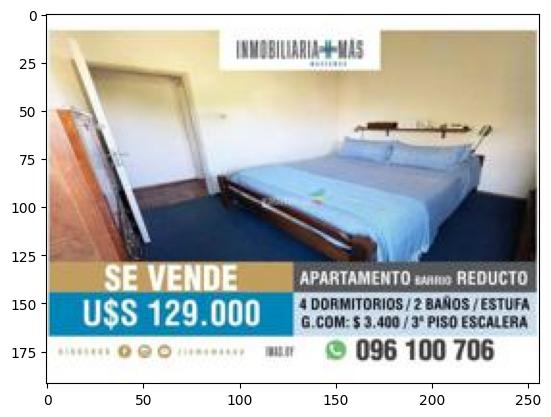

In [27]:
image1 = next(dataiter1)
plt.imshow(image1[0][0].permute(1, 2, 0))

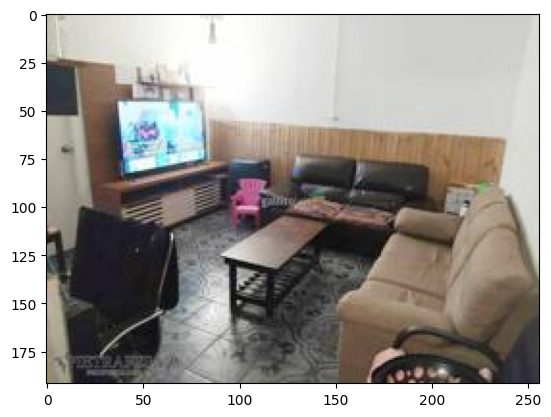

In [28]:
image2 = next(dataiter2)
plt.imshow(image2[0][0].permute(1, 2, 0))

#MODELO

In [20]:
class MLP_Model(nn.Module):
  def __init__(self,name="MLP_MODEL", vocab_size=260, embedding_dim=4, num_classes=4):
    super().__init__()
    self.name = name
    self.embedding = nn.Embedding(num_embeddings=vocab_size,embedding_dim=embedding_dim)
    # Input -> 256*192
    self.conv1 = nn.Conv2d(3, 128, 4, stride=2, padding=1, bias=False)
    # 256*192 -> conv1(1/2) -> 128*96
    self.bn1 = nn.BatchNorm2d(128)
    self.conv2 = nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False)
    # 128*96 -> conv1(1/2) -> 64*48
    self.bn2 = nn.BatchNorm2d(256)
    self.conv3 = nn.Conv2d(256, 128, 4, stride=2, padding=1, bias=False)
    # 64*48 -> conv1(1/2) -> 32*24
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 32, 4, stride=2, padding=1, bias=False)
    # 32*24 -> conv1(1/2) -> 16*12
    self.bn4 = nn.BatchNorm2d(32)
    self.conv5 = nn.Conv2d(32, 8, 4, stride=2, padding=1, bias=False)
    # 16*12 -> conv1(1/2) -> 8*6
    self.bn5 = nn.BatchNorm2d(8)
    self.conv6 = nn.Conv2d(8, 1, 4, stride=2, padding=1, bias=False)
    # 8*6 -> conv1(1/2) -> 4*3
    self.bn6 = nn.BatchNorm2d(1)
    self.linear1 = nn.Linear(1*4*3+5+(embedding_dim-1), 1024)
    self.linear2 = nn.Linear(1024, 512)
    self.linear3 = nn.Linear(512, 128)
    self.linear4 = nn.Linear(128, 64)
    self.out = nn.Linear(64, num_classes)


  def forward(self, x,tabulars):
    # entrada de 256*192
    emb_Location = self.embedding(tabulars[:,4])
    # area data scaling
    rescalArea = tabulars[:,0:1] /100.0
    #plt.imshow(x[0])
    x = x.view(x.size(0), 3, 256, 192)
    x = torch.round(x).to(torch.float32)
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.relu(self.bn4(self.conv4(x)))
    x = F.relu(self.bn5(self.conv5(x)))
    x = F.relu(self.bn6(self.conv6(x)))
    x = x.view(x.size(0), -1)
    x = torch.concat([x,rescalArea,tabulars[:,1:4], emb_Location], -1)
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = F.relu(self.linear3(x))
    x = F.relu(self.linear4(x))
    x = self.out(x)
    x = F.softmax(x,dim = 1)
    return x

In [21]:
torchinfo.summary(MLP_Model())

Layer (type:depth-idx)                   Param #
MLP_Model                                --
├─Embedding: 1-1                         1,040
├─Conv2d: 1-2                            6,144
├─BatchNorm2d: 1-3                       256
├─Conv2d: 1-4                            524,288
├─BatchNorm2d: 1-5                       512
├─Conv2d: 1-6                            524,288
├─BatchNorm2d: 1-7                       256
├─Conv2d: 1-8                            65,536
├─BatchNorm2d: 1-9                       64
├─Conv2d: 1-10                           4,096
├─BatchNorm2d: 1-11                      16
├─Conv2d: 1-12                           128
├─BatchNorm2d: 1-13                      2
├─Linear: 1-14                           21,504
├─Linear: 1-15                           524,800
├─Linear: 1-16                           65,664
├─Linear: 1-17                           8,256
├─Linear: 1-18                           260
Total params: 1,747,110
Trainable params: 1,747,110
Non-trainable params

#CORRIDA INDIVIDUAL PARAMETROS

## PARAMETROS

In [33]:
config = {
    "LR": 2e-4,
    "epochs": 5,
    "batch_size": 32,
    "B": [0.5,0.999],
    "info" : 'Modelo MLP'
}

run = wandb.init(project="MLP-Obligatorio", entity="vainilla")

config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs

config.learning_rate = 2e-4
config.epochs = 10
config.batch_size = 32
config.B = [0.5,0.999]
config.info = 'Modelo MLP'

In [34]:
# Definimos el modelo y el optimizador
LR = config.learning_rate
epochs = config.epochs
batch_size = config.batch_size
B = config.B

## ENTRENAMIENTO

In [35]:
# Creamos el loaders
train_loader, val_loader = get_dataloaders(batch_size=32, t_transform=train_transform, v_transform=val_transform, augment_data=False)

(25099, 7)
19981 Training Items, 4996 Validation Items


In [36]:
mlp_model = MLP_Model("MLP MODEL", vocab_size=260, embedding_dim=4, num_classes=4).to(device)
opt = torch.optim.Adam(mlp_model.parameters(), lr=LR,betas=B)

weights = torch.tensor([0.31, 0.07, 0.31, 0.31]).to(device)

crit = nn.CrossEntropyLoss(weight=weights)

wandb.watch(mlp_model, log_freq=100)


[]

In [37]:
train_model(mlp_model, train_loader, val_loader, crit, opt, epochs, 4)

Training epoch 2 | Loss 0.183355 | Time 100.27 seconds
Validation epoch 2 | Loss 0.171972 | Accuracy 66.85% | Time 7.35 seconds
Training epoch 3 | Loss 0.173315 | Time 99.75 seconds
Validation epoch 3 | Loss 0.167148 | Accuracy 65.61% | Time 7.33 seconds


KeyboardInterrupt: ignored

In [38]:

torch.save(mlp_model.state_dict(), '/content/model.pth')
# Save as artifact for version control.
artifact = wandb.Artifact('model', type='model')
artifact.add_file('/content/model.pth')
run.log_artifact(artifact)
run.finish()

Accuracy,█▁
Train Loss,█▁
Validation Loss,█▁
Accuracy,65.61249
Train Loss,0.17332
Validation Loss,0.16715


# GRID SEARCH W&B

In [39]:
def train_epoch_wandb(mlp_model, loader, criterion, optim,numberOfClass):
    epoch_loss_accumulated = 0.0
    for img, tabulars, labels in loader:
      batch_size = img.size(0)
      epoch_loss_accumulated += train_step(mlp_model,criterion,optim, img.to(device), tabulars.to(device), labels.to(device), batch_size,numberOfClass)
    return epoch_loss_accumulated/len(loader)

def train_wandb(config=None):
    # Initialize a new wandb run

    with wandb.init(config=config):
        # If called by wandb.agent, as below,

        # this config will be set by Sweep Controller
        config = wandb.config

        train_loader, val_loader = get_dataloaders(batch_size=32, t_transform=train_transform, v_transform=val_transform, augment_data=False)

        mlp_model = MLP_Model(name="MLP MODEL", vocab_size=200, embedding_dim=4, num_classes=4).to(device)
        params = mlp_model.parameters()
        lr = config.LR
        betas=config.B

        opt = torch.optim.Adam(params, lr=lr,betas=betas)

        weights = torch.tensor([0.31, 0.07, 0.31, 0.31]).to(device)
        crit = nn.CrossEntropyLoss(weight=weights)

        for epoch in range(config.epochs):
            train_loss = train_epoch_wandb(mlp_model, train_loader, crit, opt,4)
            val_loss, acc = validation_epoch(mlp_model, val_loader, crit)

            wandb.log({"Train Loss": train_loss})
            wandb.log({"Validation Loss": val_loss})
            wandb.log({"Accuracy": acc})



In [40]:
sweep_configuration = {
    'method': 'grid',         # 'grid', 'hyperopt', 'bayesian'
    'metric': {
        'name': 'acc',     # 'accuracy'
        'goal': 'maximize'      # 'maximize'
    },
    'parameters': {
        'batch_size': {'values': [32]},
        'epochs': {'values': [1]},
        'B': {'values': [[0.01,0.99],[0.2,0.8]]},
        'LR': {'values': [0.1]}
     }
}



In [41]:
sweep_id = wandb.sweep(sweep_configuration, project="MLP-Obligatorio", entity="vainilla")
wandb.agent(sweep_id, function=train_wandb, project='MLP-Obligatorio')

Create sweep with ID: 76vgy2nz
Sweep URL: https://wandb.ai/vainilla/MLP-Obligatorio/sweeps/76vgy2nz


wandb: Agent Starting Run: xd9nnka2 with config:
wandb: 	B: [0.01, 0.99]
wandb: 	LR: 0.1
wandb: 	batch_size: 32
wandb: 	epochs: 1


(25099, 7)
19981 Training Items, 4996 Validation Items
into train


Run xd9nnka2 errored: RuntimeError('cuDNN error: CUDNN_STATUS_INTERNAL_ERROR')
wandb: ERROR Run xd9nnka2 errored: RuntimeError('cuDNN error: CUDNN_STATUS_INTERNAL_ERROR')
wandb: Agent Starting Run: ev1hypo4 with config:
wandb: 	B: [0.2, 0.8]
wandb: 	LR: 0.1
wandb: 	batch_size: 32
wandb: 	epochs: 1


(25099, 7)
19981 Training Items, 4996 Validation Items


Run ev1hypo4 errored: RuntimeError('CUDA error: device-side assert triggered\nCUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.\nFor debugging consider passing CUDA_LAUNCH_BLOCKING=1.\nCompile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.\n')
wandb: ERROR Run ev1hypo4 errored: RuntimeError('CUDA error: device-side assert triggered\nCUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.\nFor debugging consider passing CUDA_LAUNCH_BLOCKING=1.\nCompile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.\n')
wandb: Sweep Agent: Waiting for job.
wandb: Ctrl + C detected. Stopping sweep.


# GRID SEARCH RAY

## Preparación de Búsqueda

In [25]:
from ray import tune
from ray import air
from ray.air import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler
from functools import partial


In [26]:
def train_epoch_grid(mlp_model, loader, criterion, optim,numberOfClass):
    epoch_loss_accumulated = 0.0
    for img, tabulars, labels in  loader:
      batch_size = img.size(0)
      epoch_loss_accumulated += train_step(mlp_model,criterion,optim, img.to(device), tabulars.to(device), labels.to(device), batch_size,numberOfClass)
    return epoch_loss_accumulated/len(loader)

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train_MLP_grid(config):

  #Create Model
  mlp_model = MLP_Model("MLP MODEL", vocab_size=260, embedding_dim=4, num_classes=4).to(device)

  # Criterion and Optimizer
  weights = torch.tensor([0.31, 0.07, 0.31, 0.31]).to(device)
  criterion = nn.CrossEntropyLoss(weight=weights)
  optim = torch.optim.Adam(mlp_model.parameters(), lr=config['LR'],betas=config['B'])


  train_loader, val_loader = get_dataloaders(batch_size=config['batch_size'], augment_data=False, data_dir = '/content/data.csv', image_dir = '/content/img/')


  for epoch in range(1, config['epochs']+1):
    running_loss = 0.0
    epoch_steps = 0

    train_loss = train_epoch_grid(mlp_model, train_loader, criterion, optim,numberOfClass=4)

    val_loss, acc = validation_epoch(mlp_model, val_loader, criterion)

#    checkpoint_data = {
#        "epoch": epoch,
#        "net_state_dict": net.state_dict(),
#        "optimizer_state_dict": optimizer.state_dict(),
#    }
#    checkpoint = Checkpoint.from_dict(checkpoint_data)

    #This part defines the data exported
    session.report(
        {"train_loss": train_loss, "validation_loss":val_loss, "accuracy": acc, },
#        checkpoint=checkpoint,
    )

In [28]:
config = {
    "B": tune.choice([[0.01,0.99]]),
    #"LR": tune.loguniform(1e-4, 1e-1),
    "LR": tune.choice([1e-2]),
    "batch_size": tune.choice([32]),
    "epochs": tune.choice([1])
}

tuner = tune.run(
    tune.with_resources(
        trainable= train_MLP_grid, resources={"gpu": 1}
    ),
    config=config)

== Status ==
Current time: 2023-07-02 21:24:12 (running for 00:00:00.12)
Using FIFO scheduling algorithm.
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs
Result logdir: /root/ray_results/train_MLP_grid_2023-07-02_21-24-12
Number of trials: 1/1 (1 PENDING)
+----------------------------+----------+-------+--------------+------+--------------+----------+
| Trial name                 | status   | loc   | B            |   LR |   batch_size |   epochs |
|----------------------------+----------+-------+--------------+------+--------------+----------|
| train_MLP_grid_ca36b_00000 | PENDING  |       | [0.01, 0.99] | 0.01 |           32 |        1 |
+----------------------------+----------+-------+--------------+------+--------------+----------+




2023-07-02 21:24:16,380	WARNING tune.py:192 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


== Status ==
Current time: 2023-07-02 21:24:16 (running for 00:00:03.64)
Using FIFO scheduling algorithm.
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs
Result logdir: /root/ray_results/train_MLP_grid_2023-07-02_21-24-12
Number of trials: 1/1 (1 PENDING)
+----------------------------+----------+-------+--------------+------+--------------+----------+
| Trial name                 | status   | loc   | B            |   LR |   batch_size |   epochs |
|----------------------------+----------+-------+--------------+------+--------------+----------|
| train_MLP_grid_ca36b_00000 | PENDING  |       | [0.01, 0.99] | 0.01 |           32 |        1 |
+----------------------------+----------+-------+--------------+------+--------------+----------+




2023-07-02 21:24:18,140	INFO tune.py:1111 -- Total run time: 5.44 seconds (3.64 seconds for the tuning loop).
2023-07-02 21:24:18,146	WARNING tune.py:1126 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2023-07-02 21:24:18,149	WARNING experiment_analysis.py:910 -- Failed to read the results for 1 trials:
- /root/ray_results/train_MLP_grid_2023-07-02_21-24-12/train_MLP_grid_ca36b_00000_0_B=0_01_0_99,LR=0.0100,batch_size=32,epochs=1_2023-07-02_21-24-12


Hago una corrida dummy para definir que usaré 1 GPU.

## CORRIDA DE GRID

In [21]:
search_space = {
    "B": tune.choice([[0.01,0.99]]),
    #"LR": tune.loguniform(1e-4, 1e-1),
    "LR": tune.choice([1e-3,1e-2, 1e-1]),
    "batch_size": tune.choice([32,64]),
    "epochs": tune.choice([20,25])
}

In [22]:
tuner = tune.Tuner(
    train_MLP_grid,
    #tune.with_resources(train_MLP_grid, resources={"gpu": 1})
    param_space=search_space,
    tune_config= tune.TuneConfig(num_samples=2, metric="accuracy", mode="max"),
    run_config=air.RunConfig(storage_path="./results", name="grid_search_1")
)


results = tuner.fit()

Streaming output truncated to the last 5000 lines.
+----------------------------+------------+------------------+--------------+------+--------------+----------+--------+------------------+--------------+-------------------+------------+


== Status ==
Current time: 2023-07-02 20:41:34 (running for 00:53:21.86)
Using FIFO scheduling algorithm.
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs
Current best trial: 60d2f_00000 with accuracy=13.110488390712572 and parameters={'B': [0.01, 0.99], 'LR': 0.1, 'batch_size': 64, 'epochs': 25}
Result logdir: /content/results/grid_search_1
Number of trials: 2/2 (1 RUNNING, 1 TERMINATED)
+----------------------------+------------+------------------+--------------+------+--------------+----------+--------+------------------+--------------+-------------------+------------+
| Trial name                 | status     | loc              | B            |   LR |   batch_size |   epochs |   iter |   total time (s) |   train_loss |   validation_loss |   accuracy 

2023-07-02 21:07:52,809	INFO tune.py:1111 -- Total run time: 4780.36 seconds (4780.33 seconds for the tuning loop).


Result for train_MLP_grid_60d2f_00001:
  accuracy: 12.389911929543635
  date: 2023-07-02_21-07-52
  done: false
  hostname: f85a7f5cc6c7
  iterations_since_restore: 25
  node_ip: 172.28.0.12
  pid: 4765
  time_since_restore: 2372.0108337402344
  time_this_iter_s: 94.99534201622009
  time_total_s: 2372.0108337402344
  timestamp: 1688332072
  train_loss: 0.241894082901196
  training_iteration: 25
  trial_id: 60d2f_00001
  validation_loss: 0.24458385626726512
  
Trial train_MLP_grid_60d2f_00001 completed.
== Status ==
Current time: 2023-07-02 21:07:52 (running for 01:19:40.34)
Using FIFO scheduling algorithm.
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs
Current best trial: 60d2f_00000 with accuracy=13.110488390712572 and parameters={'B': [0.01, 0.99], 'LR': 0.1, 'batch_size': 64, 'epochs': 25}
Result logdir: /content/results/grid_search_1
Number of trials: 2/2 (2 TERMINATED)
+----------------------------+------------+------------------+--------------+------+--------------+----------+-----

## ANALISIS

In [23]:
if results.errors:
    print("One of the trials failed!")
else:
    print("No errors!")

No errors!


In [24]:
results_df = results.get_dataframe()
results_df[['config/B','config/LR','config/batch_size','config/epochs','train_loss','validation_loss','accuracy']]

,config/B,config/LR,config/batch_size,config/epochs,train_loss,validation_loss,accuracy
0,"[0.01, 0.99]",0.1,64,25,0.239224,0.242459,13.110488
1,"[0.01, 0.99]",0.1,64,25,0.241894,0.244584,12.389912


In [67]:
best_result = results.get_best_result()  # Get best result object
best_config = best_result.config  # Get best trial's hyperparameters
best_logdir = best_result.log_dir  # Get best trial's logdir
best_checkpoint = best_result.checkpoint  # Get best trial's best checkpoint
best_metrics = best_result.metrics  # Get best trial's last results
best_result_df = best_result.metrics_dataframe  # Get best result as pandas dataframe

In [68]:
best_result

Result(
  metrics={'train_loss': 0.24299518995285035, 'validation_loss': 0.23966325952368936, 'accuracy': 11.729383506805444, 'done': True, 'trial_id': '89c3b_00000', 'experiment_tag': '0_B=0_01_0_99,LR=0.1000,batch_size=32,epochs=10'},
  path='/content/results/grid_search_1/train_MLP_grid_89c3b_00000_0_B=0_01_0_99,LR=0.1000,batch_size=32,epochs=10_2023-07-02_16-21-45',
  checkpoint=None
)

In [58]:
%reload_ext tensorboard

In [50]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
